In [261]:
#from google.colab import drive

#drive.mount('/content/contentdrive')

### Les importations

In [1]:
import os
# Les librairies de manipulation de données
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from PIL import Image
# Les fonctions de tensorflow
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D, Input, Multiply, Dropout

c:\Users\elgue\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Le chemin de nos données

In [2]:
#path = "/content/contentdrive/MyDrive/Deep-learning-final/data2"
path = "data2"
real_test = "real_test"

### Les constantes

In [71]:
IMAGE_SIZE = 64
BATCH_SIZE = 32
EPOCHS = 50
FT_EPOCHS = 50
labels = ['angry', 'happiness','fear','disgusted','surprised']
NUM_CLASSES = len(labels)

### Les fonctions utiles

In [5]:
# Afficher les analyses
def plot_training_analysis(history):

  # Récupérer les données d'entraînement et de validation
  acc = history.history['sparse_categorical_accuracy']
  val_acc = history.history['val_sparse_categorical_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Récupérer le nombre d'époques
  epochs = range(len(acc))

  # Afficher les courbes d'entraînement et de validation pour l'accuracy
  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()

  # Afficher les courbes d'entraînement et de validation pour la loss
  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  # Afficher les graphiques
  plt.show()

In [6]:
# Détection de visage et extraction de la région d'intérêt (ROI)
def detect_face_and_extract_roi(image, image_size):
    # Charger le classifieur de visages pré-entraîné
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Convertir l'image en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Détecter les visages dans l'image
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    # Si aucun visage n'est détecté, retourner None
    if len(faces) == 0:
        return None

    # Sélectionner le premier visage détecté
    (x, y, w, h) = faces[0]

    # Redimensionner le visage détecté à la taille spécifiée
    roi = cv2.resize(image[y:y+h, x:x+w], (image_size, image_size))

    return roi


In [7]:
# Charger les images d'un répertoire avec détection de visage et extraction de ROI
def load_data(data_path, classes, dataset='train', image_size=64):
    x = []
    y = []

    # Parcours des différents répertoires pour collecter les images
    for idx_class, class_name in enumerate(classes):
        class_dir = os.path.join(data_path, dataset, class_name)
        for item in os.listdir(class_dir):
            img_path = os.path.join(class_dir, item)
            if os.path.isfile(img_path):
                # Ouvrir l'image
                img = Image.open(img_path)
                # Conversion de l'image en RGB
                img = img.convert('RGB')
                # Détection de visage et extraction de ROI
                roi = detect_face_and_extract_roi(np.asarray(img), image_size)
                if roi is not None:
                    x.append(roi)
                    y.append(idx_class)

    # Convertir les listes en tableaux NumPy
    x = np.array(x)
    y = np.array(y).reshape(-1, 1)

    return x, y


def load_data_for_real_test(data_path, image_size=64):
    x = []
    y = []

    # Parcours des différents répertoires pour collecter les images
    for class_name in os.listdir(data_path):
        class_dir = os.path.join(data_path, class_name)
        if os.path.isdir(class_dir):
            for item in os.listdir(class_dir):
                img_path = os.path.join(class_dir, item)
                if os.path.isfile(img_path):
                    # Ouvrir l'image
                    img = Image.open(img_path)
                    # Conversion de l'image en RGB
                    img = img.convert('RGB')
                    # Redimensionner l'image
                    roi = detect_face_and_extract_roi(np.asarray(img), image_size)
                    if roi is not None:
                        x.append(roi)
                        y.append(class_name)

    # Convertir les listes en tableaux NumPy
    x = np.array(x)
    y = np.array(y)

    return x, y


In [8]:
# extraire la région de la bouche
def extract_mouths_data(data_path, classes, dataset='train', image_size=64):
    x = []
    y = []

    # Parcours des différents répertoires pour collecter les images
    for idx_class, class_name in enumerate(classes):
        class_dir = os.path.join(data_path, dataset, class_name)
        for item in os.listdir(class_dir):
            img_path = os.path.join(class_dir, item)
            if os.path.isfile(img_path):
                # Ouvrir l'image
                img = Image.open(img_path)
                # Conversion de l'image en RGB
                img = img.convert('RGB')
                # Extraire la région de la bouche
                mouth_region = extract_mouth_from_image(np.asarray(img), image_size)
                if mouth_region is not None:
                    x.append(mouth_region)
                    y.append(idx_class)

    # Convertir les listes en tableaux NumPy
    x = np.array(x)
    y = np.array(y).reshape(-1, 1)

    return x, y

def extract_mouth_from_image(image, image_size=64):
    # Charger le classifieur de visages pré-entraîné
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Convertir l'image en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Détecter les visages dans l'image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Si au moins un visage est détecté, extraire la région de la bouche
    if len(faces) > 0:
        x, y, w, h = faces[0]  # Utiliser le premier visage détecté
        mouth_region = image[y + h//2:y + h, x:x + w]  # Extraire la région de la bouche
        # Redimensionner la région de la bouche si nécessaire
        if image_size is not None:
            mouth_region = cv2.resize(mouth_region, (image_size, image_size))
        return mouth_region
    else:
        return None


In [83]:
# Matrice de confusion
def plot_confusion_matrix(x, y, classes, model, normalize=True, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Matrice de confusion normalisée'
        else:
            title = 'Matrice de confusion non normalisée'

    # Convertir les prédictions du modèle en classes
    y_pred = np.argmax(model.predict(x), axis=1)

    # Calcul de la matrice de confusion
    cm = confusion_matrix(y, y_pred)

    # Normalisation de la matrice de confusion si nécessaire
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matrice de confusion normalisée")
    else:
        print('Matrice de confusion non normalisée')

    # Affichage de la matrice de confusion
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.xlabel('Classe Prédite')
    plt.ylabel('Classe Réelle')
    plt.title(title)
    plt.show()
    
def plot_confusion_matrix_vgg16(x_test, y_test, model_vgg16, base_model, labels, normalize=True, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Matrice de confusion normalisée'
        else:
            title = 'Matrice de confusion non normalisée'

    # Obtenir les caractéristiques des images de test à partir du modèle VGG19
    features_test = base_model.predict(x_test)
    
    # Aplatir les caractéristiques
    features_test = features_test.reshape((features_test.shape[0], -1))
    
    # Prédiction des étiquettes sur les données de test
    y_pred = np.argmax(model_vgg16.predict(features_test), axis=1)
    
    # Création de la matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    
    # Normalisation de la matrice de confusion si nécessaire
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matrice de confusion normalisée")
    else:
        print('Matrice de confusion non normalisée')

    # Affichage de la matrice de confusion
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Classe Prédite')
    plt.ylabel('Classe Réelle')
    plt.title(title)
    plt.show()



In [84]:
def calculate_accuracy(x_test, y_test, model):
    # Prédiction sur les données de test
    y_pred = np.argmax(model.predict(x_test), axis=1)

    # Conversion des tableaux en une dimension
    y_test = y_test.ravel()
    y_pred = y_pred.ravel()

    # Calcul de l'exactitude par classe
    global_accuracy = 0
    unique_classes = np.unique(np.concatenate([y_test, y_pred]))
    class_accuracies = {}
    for cls in unique_classes:
        cls_indices = np.where(y_test == cls)[0]
        cls_correct_predictions = np.sum(y_pred[cls_indices] == cls)
        cls_total_samples = len(cls_indices)
        cls_accuracy = cls_correct_predictions / cls_total_samples if cls_total_samples != 0 else 0
        class_accuracies[cls] = cls_accuracy
        global_accuracy += cls_accuracy
        print(f"La précision pour la classe {labels[cls]} :", cls_accuracy)

    # Précision globale du modèle
    print("La précision globale :", global_accuracy / len(labels))


def calculate_accuracy_vgg16(x_test, y_test, model_vgg16, base_model):
    # Extraction des caractéristiques des données de test en utilisant le modèle de base VGG19
    x_vgg16_test = base_model.predict(x_test)
    x_vgg16_test = np.reshape(x_vgg16_test, (x_vgg16_test.shape[0], 2*2*512))

    # Prédiction sur les données de test
    y_pred = np.argmax(model_vgg16.predict(x_vgg16_test), axis=1)

    # Conversion des tableaux en une dimension
    y_test = y_test.ravel()
    y_pred = y_pred.ravel()

    # Calcul de l'exactitude par classe
    global_accuracy = 0
    unique_classes = np.unique(np.concatenate([y_test, y_pred]))
    class_accuracies = {}
    for cls in unique_classes:
        cls_indices = np.where(y_test == cls)[0]
        cls_correct_predictions = np.sum(y_pred[cls_indices] == cls)
        cls_total_samples = len(cls_indices)
        cls_accuracy = cls_correct_predictions / cls_total_samples if cls_total_samples != 0 else 0
        class_accuracies[cls] = cls_accuracy
        global_accuracy += cls_accuracy
        print(f"La précision pour la classe {labels[cls]} :", cls_accuracy)

    # Précision globale du modèle
    print("La précision globale :", global_accuracy / len(labels))



### Chargement des données

In [35]:
x_train, y_train = load_data(path, labels, dataset='train', image_size=IMAGE_SIZE)
#print(x_train.shape, y_train.shape)

x_val, y_val = load_data(path, labels, dataset='validation', image_size=IMAGE_SIZE)
#print(x_val.shape, y_val.shape)

x_test, y_test = load_data(path, labels, dataset='test', image_size=IMAGE_SIZE)
#print(x_test.shape, y_test.shape)

x_real_test, y_real_test = load_data_for_real_test(real_test, image_size=IMAGE_SIZE)

x_train = x_train / 255
x_val = x_val / 255
x_test = x_test / 255

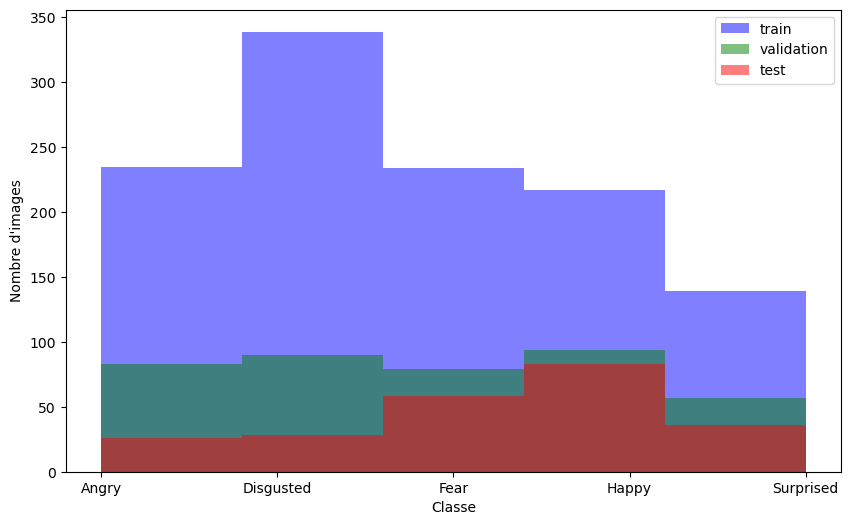

In [36]:
# Définir les étiquettes des émotions
emotion_labels = ['Angry', 'Disgusted', 'Fear', 'Happy', 'Surprised']

# Graphe pour afficher le nombre d'images par classe avec des couleurs pour différencier les ensembles d'entraînement, de validation et de test
plt.figure(figsize=(10, 6))
plt.hist(y_train, bins=5, alpha=0.5, label='train', color='blue')
plt.hist(y_val, bins=5, alpha=0.5, label='validation', color='green')
plt.hist(y_test, bins=5, alpha=0.5, label='test', color='red')

# Ajouter les étiquettes des émotions sur l'axe x
plt.xticks(range(5), emotion_labels)

plt.xlabel('Classe')
plt.ylabel("Nombre d'images")
plt.legend()
plt.show()


In [273]:
# Données des bouches (on a essayé de faire un entrainement du modèle sur les bouches des personnes pour identifier les emotions) !!! La précision n'a pas augmenté

#x_train, y_train = extract_mouths_data(path, labels, dataset='train', image_size=IMAGE_SIZE)
#x_val, y_val = extract_mouths_data(path, labels, dataset='validation', image_size=IMAGE_SIZE)
#x_test, y_test = extract_mouths_data(path, labels, dataset='test', image_size=IMAGE_SIZE)

In [274]:
# Normalisation des données
#x_train = x_train/255
#x_val = x_val/255
#x_test = x_test/255

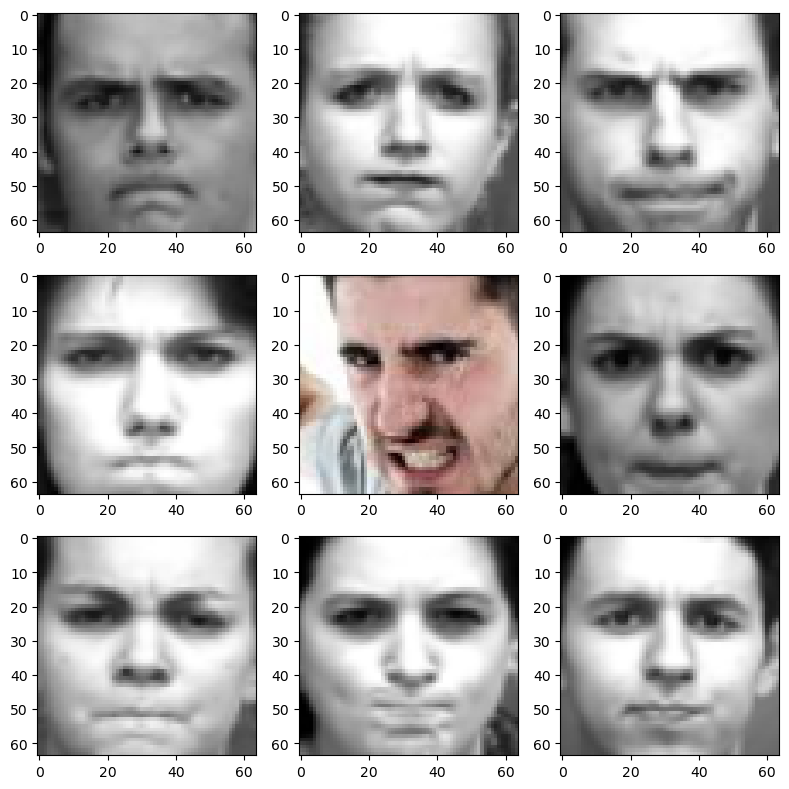

In [37]:
indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)
plt.figure(figsize=(8, 8))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_train[i])
plt.tight_layout()
plt.show()

### Générer plus de données

In [44]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.05,
    horizontal_flip=True,    
    )

gen_data = train_datagen.flow(x_train, y_train, BATCH_SIZE)

In [277]:
#x_gen, y_gen = next(gen_data)
#x_gen_img, y_gen_img = x_gen/255, y_gen/255
#indices = np.arange(x_gen_img.shape[0])
#np.random.shuffle(indices)
#plt.figure(figsize=(8, 8))
#for i in range(0, 9):
    #plt.subplot(3, 3, i+1)
    #plt.imshow(x_gen_img[i])
#plt.tight_layout()
#plt.show()

### Modèle simple

In [45]:
# Définition du modèle
model_simple = Sequential()

model_simple.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model_simple.add(MaxPooling2D((2, 2)))

model_simple.add(Conv2D(64, (3, 3), activation='relu'))
model_simple.add(MaxPooling2D((2, 2)))

model_simple.add(Conv2D(96, (3, 3), activation='relu'))
model_simple.add(MaxPooling2D((2, 2)))

model_simple.add(Conv2D(128, (3, 3), activation='relu'))
model_simple.add(MaxPooling2D((2, 2)))

model_simple.add(Flatten())

model_simple.add(Dense(512, activation='relu'))
model_simple.add(Dense(NUM_CLASSES, activation="softmax"))  # 6 classes d'émotions différentes

c:\Users\elgue\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [47]:
# Compiler le modèle
model_simple.summary()
model_simple.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-4), metrics=['sparse_categorical_accuracy'])

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 128)      │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 450,725 (1.72 MB)

 Trainable params: 450,725 (1.72 MB)

 Non-trainable params: 0 (0.00 B)

##### Entrainer le modèle

In [52]:
# Entraînement du modèle
history_simple = model_simple.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100)

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.8077 - sparse_categorical_accuracy: 0.6929 - val_loss: 1.0568 - val_sparse_categorical_accuracy: 0.5881
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.7909 - sparse_categorical_accuracy: 0.7085 - val_loss: 1.1526 - val_sparse_categorical_accuracy: 0.5881
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.7537 - sparse_categorical_accuracy: 0.7261 - val_loss: 1.1863 - val_sparse_categorical_accuracy: 0.5261
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.7860 - sparse_categorical_accuracy: 0.7109 - val_loss: 1.0967 - val_sparse_categorical_accuracy: 0.5707
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.7168 - sparse_categorical_accuracy: 0.7491 - val_loss: 1.0602 - val_sparse_categorical_accuracy: 0.5980
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.6664 - sparse_categorical_accuracy: 0.7679 - val_loss: 1.1172 - val_sparse_categorical_accuracy: 0.6104
Epoc

##### Analyser les résultats

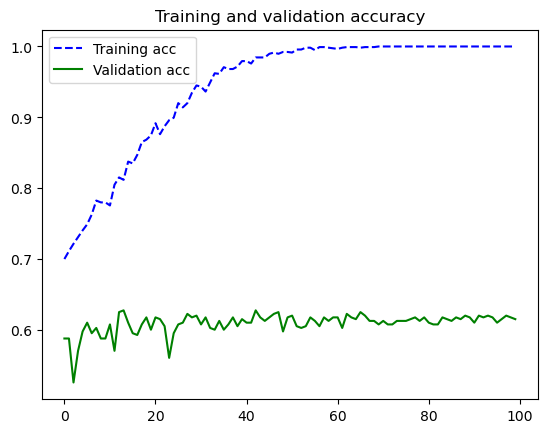

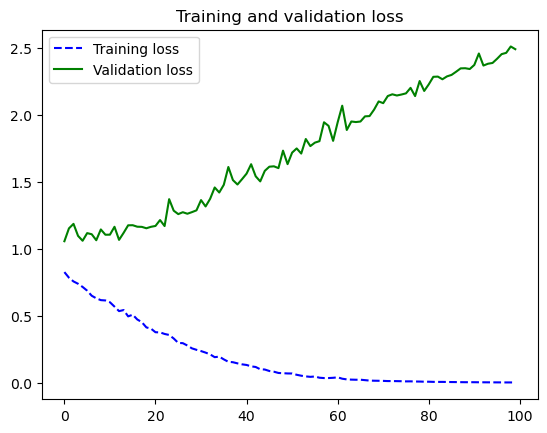

In [53]:
# Affichage les courbes
plot_training_analysis(history_simple)

##### Matrice de confusion

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Matrice de confusion normalisée


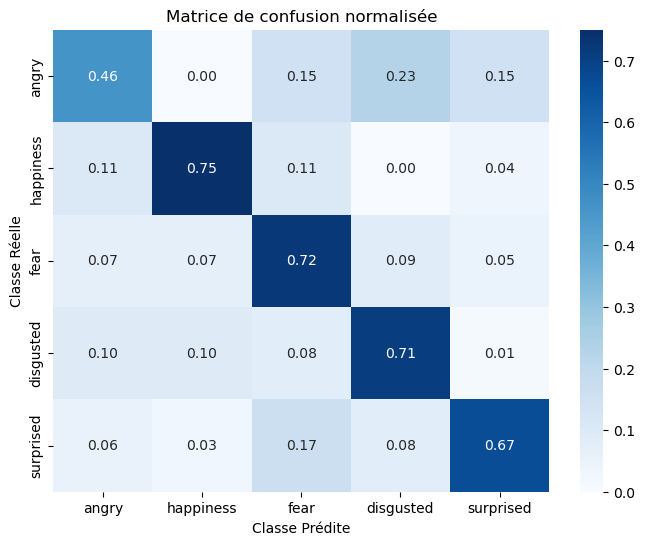

In [54]:
# Matrice de confusion
plot_confusion_matrix(x_test, y_test, labels, model_simple)

##### Précision globale et par classe (modèle simple)

In [55]:
calculate_accuracy(x_test, y_test, model_simple)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
La précision pour la classe angry : 0.46153846153846156
La précision pour la classe happiness : 0.75
La précision pour la classe fear : 0.7241379310344828
La précision pour la classe disgusted : 0.7108433734939759
La précision pour la classe surprised : 0.6666666666666666
La précision globale : 0.6626372865467174


##### Prediction réelle

In [56]:
# Prédire les émotions sur les images du real test afficher la photo, l'emotion prédite et l'emotion réelle, calculer la précision globale et la précision par classe
y_real_test_pred = np.argmax(model_simple.predict(x_real_test), axis=1)
accuracy_global = 0
for i in range(len(y_real_test)):
    #plt.imshow(x_real_test[i])
    pred = labels[y_real_test_pred[i]]
    real = y_real_test[i]
    #plt.title(f"Emotion prédite: {pred}, Emotion réelle: {real}")
    #plt.show()
    if pred == real:
        accuracy_global += 1
        
print(f"Précision globale: {accuracy_global/len(y_real_test)}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Précision globale: 0.21666666666666667


### Modèle VGG16

In [57]:
base_model = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(64, 64, 3))
# Le modèle simple
base_model.summary()


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

##### Entrainer le modèle

In [58]:
# Chargement du modèle VGG16 et de ses caractéristiques
train_features = base_model.predict(x_train)
train_features = np.reshape(train_features,(train_features.shape[0],2*2*512))

val_features = base_model.predict(x_val)
val_features = np.reshape(val_features,(val_features.shape[0],2*2*512))

# Entraînement du modèle
#history_vgg19 = model_vgg19.fit(x_vgg19_train, y_train, validation_data=(x_vgg19_val, y_val), epochs=EPOCHS)

model = Sequential()
model.add(Dense(256, activation='relu', input_dim=2*2*512))
model.add(Dropout(0.5)) # On utilise du DropOut sur cette couche dense car elle comporte un grand nombre
                               # de paramètres et risque d'être très sujette au sur-apprentissage.
model.add(Dense(NUM_CLASSES, activation="softmax"))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['sparse_categorical_accuracy'])

history = model.fit(train_features, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(val_features, y_val))

37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step
Epoch 1/50


c:\Users\elgue\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.8957 - sparse_categorical_accuracy: 0.2374 - val_loss: 1.5072 - val_sparse_categorical_accuracy: 0.3201
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4673 - sparse_categorical_accuracy: 0.3879 - val_loss: 1.4067 - val_sparse_categorical_accuracy: 0.3449
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2463 - sparse_categorical_accuracy: 0.5114 - val_loss: 1.3606 - val_sparse_categorical_accuracy: 0.4417
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2114 - sparse_categorical_accuracy: 0.5039 - val_loss: 1.3209 - val_sparse_categorical_accuracy: 0.4144
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1604 - sparse_categorical_accuracy: 0.5244 - val_loss: 1.2889 - val_sparse_categorical_accuracy: 0.4417
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0690 - sparse_categorical_accuracy: 0.6005 - val_loss: 1.2683 - val_sparse_categorical_accuracy: 0.4640
Epoch 7/50
37/37 ━━━━━━━━━

##### Affichage des résultats

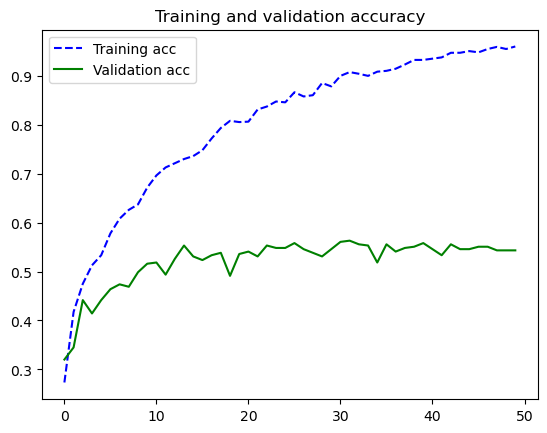

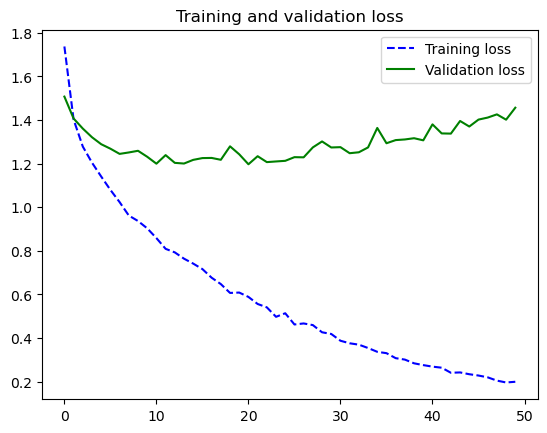

In [59]:
# Affichage les courbes
plot_training_analysis(history)

##### Matrice de confusion

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Matrice de confusion normalisée


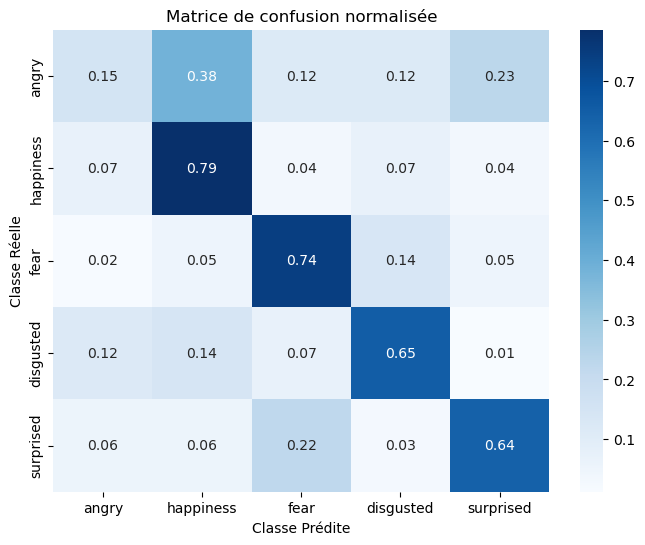

In [60]:
# Matrice de confusion
plot_confusion_matrix_vgg16(x_test, y_test, model, base_model, labels)

##### Précision globale et par classe (sans fine tuning)

In [61]:
calculate_accuracy_vgg16(x_test, y_test, model, base_model)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
La précision pour la classe angry : 0.15384615384615385
La précision pour la classe happiness : 0.7857142857142857
La précision pour la classe fear : 0.7413793103448276
La précision pour la classe disgusted : 0.6506024096385542
La précision pour la classe surprised : 0.6388888888888888
La précision globale : 0.594086209686542


augmentation des données

In [62]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))
base_model.trainable = False
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [64]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-5),
              metrics=['sparse_categorical_accuracy'])

history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(x_val, y_val),
    epochs=50,
)

Epoch 1/50


c:\Users\elgue\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 337ms/step - loss: 1.5769 - sparse_categorical_accuracy: 0.2896 - val_loss: 1.5985 - val_sparse_categorical_accuracy: 0.2258
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 331ms/step - loss: 1.5419 - sparse_categorical_accuracy: 0.2968 - val_loss: 1.5974 - val_sparse_categorical_accuracy: 0.2407
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - loss: 1.5199 - sparse_categorical_accuracy: 0.3278 - val_loss: 1.5853 - val_sparse_categorical_accuracy: 0.2581
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 339ms/step - loss: 1.4756 - sparse_categorical_accuracy: 0.3657 - val_loss: 1.5796 - val_sparse_categorical_accuracy: 0.2705
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 315ms/step - loss: 1.4707 - sparse_categorical_accuracy: 0.3809 - val_loss: 1.5648 - val_sparse_categorical_accuracy: 0.2928
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 306ms/step - loss: 1.4677 - sparse_categorical_accuracy: 0.3704 - val_loss: 1.5769 - val_sparse_categorical_accuracy: 0.2829
Epoch 7/5

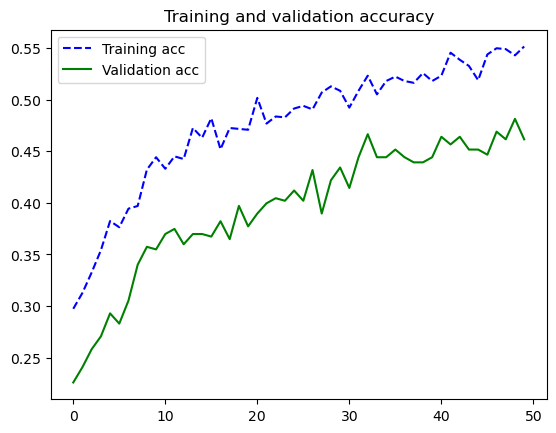

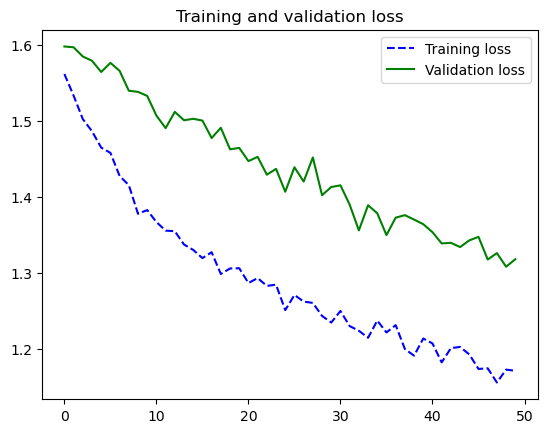

In [65]:
plot_training_analysis(history)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step
Matrice de confusion normalisée


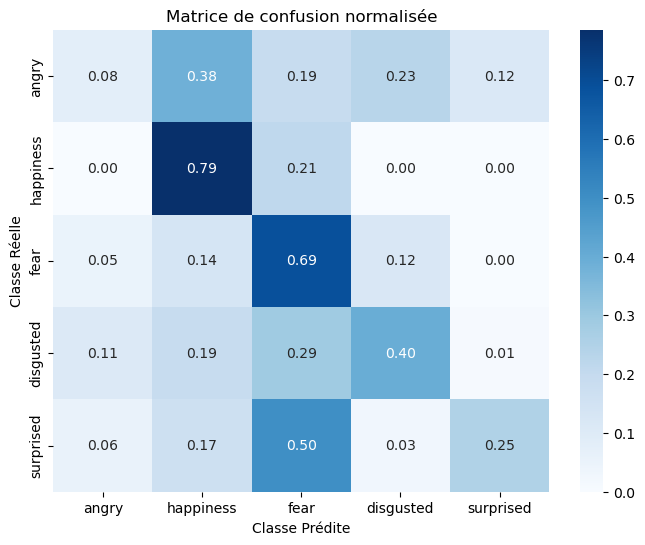

In [66]:
# Matrice de confusion
plot_confusion_matrix(x_test, y_test, labels, model)

##### précision globale et par classe (avec fine tuning)

In [87]:
calculate_accuracy(x_test, y_test, model)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step
La précision pour la classe angry : 0.3076923076923077
La précision pour la classe happiness : 0.8214285714285714
La précision pour la classe fear : 0.7931034482758621
La précision pour la classe disgusted : 0.7108433734939759
La précision pour la classe surprised : 0.6388888888888888
La précision globale : 0.6543913179559212


## fine tuning

In [68]:
base_model.trainable = True
model.summary()



Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,292,177 (62.15 MB)

 Trainable params: 15,240,517 (58.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,051,660 (4.01 MB)

Epoch 1/20


c:\Users\elgue\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 40s 982ms/step - loss: 1.1829 - sparse_categorical_accuracy: 0.5085 - val_loss: 1.3192 - val_sparse_categorical_accuracy: 0.5285
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - loss: 1.0885 - sparse_categorical_accuracy: 0.5618 - val_loss: 1.1653 - val_sparse_categorical_accuracy: 0.5558
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 35s 925ms/step - loss: 1.0514 - sparse_categorical_accuracy: 0.5914 - val_loss: 1.1841 - val_sparse_categorical_accuracy: 0.5459
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 33s 884ms/step - loss: 0.9602 - sparse_categorical_accuracy: 0.6192 - val_loss: 1.1666 - val_sparse_categorical_accuracy: 0.5658
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 32s 858ms/step - loss: 0.9262 - sparse_categorical_accuracy: 0.6204 - val_loss: 1.1363 - val_sparse_categorical_accuracy: 0.5583
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 32s 861ms/step - loss: 0.8817 - sparse_categorical_accuracy: 0.6640 - val_loss: 1.2236 - val_sparse_categorical_accuracy: 0.5633
Epoch 7/20
3

In [72]:
model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizers.Adam(learning_rate=1e-5),
                metrics=['sparse_categorical_accuracy'])

history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(x_val, y_val),
    epochs=FT_EPOCHS,
)

Epoch 1/50


c:\Users\elgue\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 39s 946ms/step - loss: 0.4701 - sparse_categorical_accuracy: 0.8359 - val_loss: 1.1490 - val_sparse_categorical_accuracy: 0.6352
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 32s 866ms/step - loss: 0.4156 - sparse_categorical_accuracy: 0.8485 - val_loss: 1.3008 - val_sparse_categorical_accuracy: 0.6303
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 33s 896ms/step - loss: 0.4098 - sparse_categorical_accuracy: 0.8487 - val_loss: 1.1708 - val_sparse_categorical_accuracy: 0.6427
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 32s 859ms/step - loss: 0.4106 - sparse_categorical_accuracy: 0.8435 - val_loss: 1.2530 - val_sparse_categorical_accuracy: 0.6104
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 32s 863ms/step - loss: 0.3764 - sparse_categorical_accuracy: 0.8632 - val_loss: 1.2122 - val_sparse_categorical_accuracy: 0.6328
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 32s 862ms/step - loss: 0.3884 - sparse_categorical_accuracy: 0.8677 - val_loss: 1.2169 - val_sparse_categorical_accuracy: 0.6278
Epoch 7/5

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step
Matrice de confusion normalisée


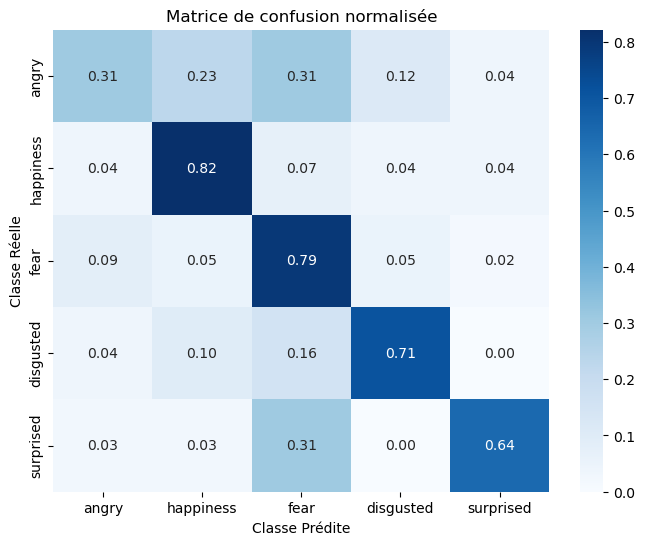

In [73]:
# Matrice de confusion
plot_confusion_matrix(x_test, y_test, labels, model)

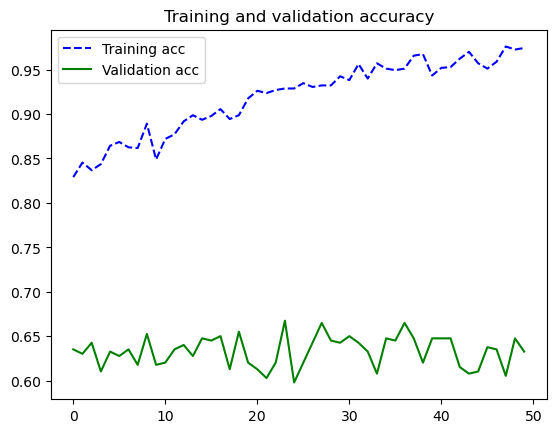

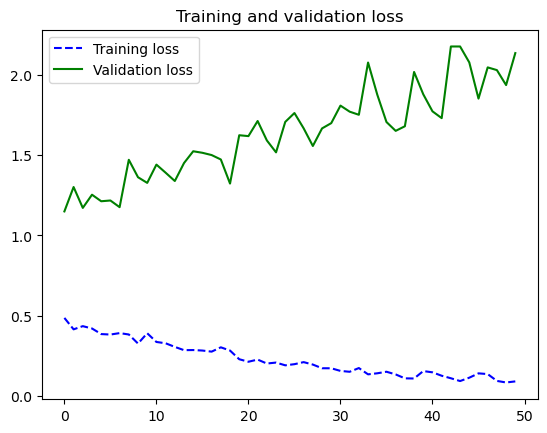

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step
La précision pour la classe angry : 0.3076923076923077
La précision pour la classe happiness : 0.8214285714285714
La précision pour la classe fear : 0.7931034482758621
La précision pour la classe disgusted : 0.7108433734939759
La précision pour la classe surprised : 0.6388888888888888
La précision globale : 0.6543913179559212


In [85]:
plot_training_analysis(history)


 précision globale et par classe (avec fine tuning)

In [86]:
calculate_accuracy(x_test, y_test, model)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step
La précision pour la classe angry : 0.3076923076923077
La précision pour la classe happiness : 0.8214285714285714
La précision pour la classe fear : 0.7931034482758621
La précision pour la classe disgusted : 0.7108433734939759
La précision pour la classe surprised : 0.6388888888888888
La précision globale : 0.6543913179559212
